# Data Augmentation Box

Project for Data Augmentation System

## Data Augmentation Order

STEP 1 - Domain Data Preparation
1. Domain data labeling check
2. Dimensionality Reduction
3. Regression analysis


STEP 2 - Data Augmentation
1. Domain data check
02. Public Data Supplement
03. Data filtering (1st)
04. Dimensionality Reduction
05. Label Spreading (semi-supervised learning based)
06. Data Filtering (2nd)
07. Regression analytsis
08. Data Filtering (3rd)
09. Data Augmentation
10. Model Generation

- - -

In [58]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [155]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

scaler = MinMaxScaler() #set the scaler

## 01. Domain Data Check

we have to check the domain data 

### 1-1) image dataset

### 1-2) numerical dataset

In [85]:
### HRV numerical dataset
domain = pd.read_csv('E:/RESEARCH/Datasets/HRV/HRV_REV_all.csv', sep=',')

In [86]:
### data shape, variables check
print("The shape of the domain dataset is:",domain.shape)
# print(domain.columns)
domain.head()

The shape of the domain dataset is: (479, 93)


,sub,VISIT,disorder,age,gender,HAMD,HAMA,PDSS,ASI,APPQ,...,cRMSSD,cVLF,cLF,cHF,cLF/HF,cPOWER,cHR,cRESP,cSC,cTEMP
0,E001,4,2,23,1,2,2,1,12,22,...,41.544667,190.107000,298.508333,206.862333,1.284000,695.477333,65.707000,14.054333,3.911333,34.998000
1,E001,5,2,23,1,12,7,0,12,24,...,39.825333,143.756667,115.695333,202.602667,0.585000,462.054667,69.040000,14.117333,6.255000,35.544333
2,E002,1,2,38,1,14,17,14,31,122,...,20.052000,22.006000,50.182000,32.529333,2.499333,104.717000,92.789333,11.013333,0.945667,35.086000
3,E002,2,2,38,1,13,36,16,32,139,...,20.201667,55.579000,84.441000,18.754000,5.803000,158.774333,85.980667,12.608333,0.785667,36.141000
4,E002,3,2,38,1,7,10,11,23,70,...,74.788000,182.229000,530.565667,546.574000,1.685667,1259.368667,84.368667,14.285667,0.648000,35.879000


* HAMD 점수에 따라서 새롭게 IndexH 라고 라벨링용 변수 만들어주자

In [87]:
### checking lables for the data
domain.loc[domain['HAMD']<=7, 'IndexH'] =0
domain.loc[(domain['HAMD']>7) & (domain['HAMD']<=16), 'IndexH'] = 1
domain.loc[domain['HAMD']>16, 'IndexH'] = 2
domain_y = domain.loc[:,'IndexH']
# domain_y = domain.loc[:,'disorder']

* 그리고 안쓸 변수들은 제거해주자. (HRV 관련 변수만 쓸 것임)

In [88]:
### deleting unnecessary data columns
domain = domain.drop(['sub','age','gender','VISIT','disorder','HAMD', 'HAMA','PDSS','ASI','APPQ','PSWQ','SPI','PSS','BIS','SSI'], axis=1)

In [89]:
### check the domain data columns again
print(domain.columns)
print(domain.shape)

Index(['b1SDNN', 'b1NN50', 'b1PNN50', 'b1RMSSD', 'b1VLF', 'b1LF', 'b1HF',
       'b1LF/HF', 'b1POWER', 'b1HR', 'b1RESP', 'b1SC', 'b1TEMP', 'sSDNN',
       'sNN50', 'sPNN50', 'sRMSSD', 'sVLF', 'sLF', 'sHF', 'sLF/HF', 'sPOWER',
       'sHR', 'sRESP', 'sSC', 'sTEMP', 'b2SDNN', 'b2NN50', 'b2PNN50',
       'b2RMSSD', 'b2VLF', 'b2LF', 'b2HF', 'b2LF/HF', 'b2POWER', 'b2HR',
       'b2RESP', 'b2SC', 'b2TEMP', 'rSDNN', 'rNN50', 'rPNN50', 'rRMSSD',
       'rVLF', 'rLF', 'rHF', 'rLF/HF', 'rPOWER', 'rHR', 'rRESP', 'rSC',
       'rTEMP', 'b3SDNN', 'b3NN50', 'b3PNN50', 'b3RMSSD', 'b3VLF', 'b3LF',
       'b3HF', 'b3LF/HF', 'b3POWER', 'b3HR', 'b3RESP', 'b3SC', 'b3TEMP',
       'cSDNN', 'cNN50', 'cPNN50', 'cRMSSD', 'cVLF', 'cLF', 'cHF', 'cLF/HF',
       'cPOWER', 'cHR', 'cRESP', 'cSC', 'cTEMP', 'IndexH'],
      dtype='object')
(479, 79)


- - -

* Domain data variable selection for the right task
> baseline, stress, rest phase로 나눠진 데이터를 각각 쪼개주는 것.

In [90]:
domain_b1 = domain.loc[:, ['b1RMSSD', 'b1HR', 'b1PNN50', 'b1VLF', 'b1LF', 'b1HF', 'b1LF/HF']]
domain_b2 = domain.loc[:, ['b2RMSSD', 'b2HR', 'b2PNN50', 'b2VLF', 'b2LF', 'b2HF', 'b2LF/HF']]
domain_b3 = domain.loc[:, ['b3RMSSD', 'b3HR', 'b3PNN50', 'b3VLF', 'b3LF', 'b3HF', 'b3LF/HF']]

In [91]:
domain_b1.columns = ['RMSSD', 'HR', 'PNN50', 'VLF', 'LF', 'HF', 'LF_HF']
domain_b2.columns = ['RMSSD', 'HR', 'PNN50', 'VLF', 'LF', 'HF', 'LF_HF']
domain_b3.columns = ['RMSSD', 'HR', 'PNN50', 'VLF', 'LF', 'HF', 'LF_HF']

* domain_s 는 stress phase에 있는 애들

In [92]:
domain_s = domain.loc[:, ['sRMSSD','sHR', 'sPNN50', 'sVLF', 'sLF', 'sHF', 'sLF/HF']]
domain_s_index = domain.loc[:, ['sRMSSD','sHR', 'sPNN50', 'sVLF', 'sLF', 'sHF', 'sLF/HF', 'IndexH']]

In [93]:
domain_s.columns = ['RMSSD', 'HR', 'PNN50', 'VLF', 'LF', 'HF', 'LF_HF']

In [94]:
### Standardization
domain_b1[:] = scaler.fit_transform(domain_b1[:])
domain_b2[:] = scaler.fit_transform(domain_b2[:])
domain_b3[:] = scaler.fit_transform(domain_b3[:])
domain_s[:] = scaler.fit_transform(domain_s[:])

Later you can select the dataset that you want to analyze. 

ex) if you want to augment the stress phase dataset, choose domain_s

- - -

--------

## 02. Public Data Supplement

we proceed data crawling to support insufficient data environment

### 2-1) Crawling Image data 

In [16]:
# import urllib.request
# import time
# from urllib.parse import quote_plus
# from bs4 import BeautifulSoup
# from selenium import webdriver
# from icrawler.builtin import GoogleImageCrawler

In [17]:
# google_crawler = GoogleImageCrawler(parser_threads=2, downloader_threads=4,
#                                     storage={'root_dir': 'E:/RESEARCH/Datasets/HRV/crawl_test'})

# google_crawler.crawl(keyword='car crash', max_num=500,
# #                      date_min=None, date_max=None,
#                      min_size=(200,200), max_size=None)

In [18]:
# ### image crawling from google with GoogleImageCrawler
# google_crawler = GoogleImageCrawler(
#     feeder_threads=1,
#     parser_threads=1,
#     downloader_threads=4,
#     storage={'root_dir': 'E:/RESEARCH/Datasets/VC/classic/violin'})
# #     storage={'root_dir': 'E:/RESEARCH/Datasets/image/CIFAR_PUB/truck'}) #set the storage root

# filters = dict(
# #     type='photo',
#     #type=photo,face,clipart,linedrawing,animated
#     size='medium',
#     #size=large, medium, icon, or larger than a given size e.g.">640x480" or exactly giving size"=1024x768
# #     color='orange',
#     #coler=blackandwhite, red, oragne, yellow, green, teal, blue, purple, pink, white, gray, black, brown
# #     license='commercial,modify',
#     #license=noncommercial, commercial, noncommercial,modify , commercial,modify
#     date=((2000, 1, 1), (2021, 12, 30)))

# # type the keyword of the image that you want to crawl from google
# google_crawler.crawl(keyword= 'violin orchestra', filters=filters, offset=0, max_num=1000,
#                      min_size=(200,200), max_size=None, file_idx_offset=0)

In [19]:
# ### image crawling from google with GoogleImageCrawler
# google_crawler = GoogleImageCrawler(
#     feeder_threads=1,
#     parser_threads=1,
#     downloader_threads=4,
#     storage={'root_dir': 'E:/RESEARCH/Datasets/HRV/crawl_test'}) #set the storage root

# filters = dict(
#     #type=photo,face,clipart,linedrawing,animated
#     size='large',
#     #size=large, medium, icon, or larger than a given size e.g.">640x480" or exactly giving size"=1024x768
#     color='blackandwhite',
#     #coler=blackandwhite, red, oragne, yellow, green, teal, blue, purple, pink, white, gray, black, brown
#     license='commercial,modify',
#     #license=noncommercial, commercial, noncommercial,modify , commercial,modify
#     date=((2021, 1, 1), (2021, 12, 30)))

# # type the keyword of the image that you want to crawl from google
# google_crawler.crawl(keyword='lung ct', filters=filters, offset=0, max_num=1000,
#                      min_size=(200,200), max_size=None, file_idx_offset=0)

### 2-2) Getting Numerical Data

maybe from kaggle, google, or uci machine learning dataset

In [20]:
### In our medical case, we adopt HRV dataset from SWEEL HRV research
### Using public data must be very careful, and researchers should only use them for training data supplement.

public = pd.read_csv('E:/RESEARCH/Datasets/HRV/HRV_Public/SWELL_hrv/data/final/train.csv', sep=',')

In [23]:
### data shape, variables check
print("The shape of the public SWELL dataset is:",public.shape)
# print(public.columns)
public.head()

The shape of the public SWELL dataset is: (369289, 36)


,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,PNN50,SD1,...,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
0,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,11.001565,...,15.522602,0.421047,1.514737,3686.666157,65.018055,0.015380,2.139754,1.163485,2,no stress
1,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,9.170129,...,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055,2.174499,1.084711,2,interruption
2,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,11.533417,...,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607,2.135350,1.176315,2,interruption
3,881.757864,893.460030,90.370537,15.720468,15.720068,5.748591,68.809562,11.800000,0.133333,11.119476,...,18.181913,0.529387,1.775294,3434.520980,55.328701,0.018074,2.178341,1.179688,2,no stress
4,809.625331,811.184865,62.766242,19.213819,19.213657,3.266724,74.565728,20.200000,0.200000,13.590641,...,48.215822,1.839473,3.279993,2621.175204,29.487873,0.033912,2.221121,1.249612,2,no stress


- - -

* preprocess our data to fit into domain data
> 실제 사용하는 domain(삼성병원)데이터는 3phase를 가지지만 public에서는 baseline이랑 stress를 나눠본다

In [24]:
### set the variables same as domain dataset
public_b = public[public['condition'] == 'no stress']
public_s1 = public[public['condition'] == 'interruption']
public_s2 = public[public['condition'] == 'time pressure']

* 각각 데이터가 몇개씩이나 있는지 확인

In [25]:
### check the number of each phase dataset
print(public_b.shape)
print(public_s1.shape)
print(public_s2.shape)

(200082, 36)
(105150, 36)
(64057, 36)


In [26]:
### now select the common(repeated) variables from the domain data and save
public = public.loc[:,['RMSSD', 'HR', 'PNN50', 'VLF', 'LF', 'HF', 'LF_HF']]
public_b = public_b.loc[:,['RMSSD', 'HR', 'PNN50', 'VLF', 'LF', 'HF', 'LF_HF']]
public_s1 = public_s1.loc[:,['RMSSD', 'HR', 'PNN50', 'VLF', 'LF', 'HF', 'LF_HF']]
public_s2 = public_s2.loc[:,['RMSSD', 'HR', 'PNN50', 'VLF', 'LF', 'HF', 'LF_HF']]

* 마찬가지로 scaler 적용해서 standardization 적용

In [27]:
### standardization on supplemented dataset
public_b[:] = scaler.fit_transform(public_b[:])
public_s1[:] = scaler.fit_transform(public_s1[:])
public_s2[:] = scaler.fit_transform(public_s2[:])

In [28]:
### round up the variable values for fifth decimal points
public_b = public_b.round(decimals=5)
public_s1 = public_s1.round(decimals=5)
public_s2 = public_s2.round(decimals=5)

- - -

## 03. Data Filtering (1st)

### 3-1) Data Mergence

In [64]:
### First select the data phase (maybe not necessary for some dataset)
### Then, check the number of data in each domain and public dataset
### Here we are going to use baseline phase

print("Shape of the domain dataset for the training is", domain_s.shape)
print("Shape of the public dataset for the training is", public_s1.shape)

Shape of the domain dataset for the training is (479, 7)
Shape of the public dataset for the training is (105150, 7)


In [65]:
### select the proper amount of dataset for each
domain_resized = domain_s.sample(frac=1) ##sampling 뽑을거도 없이 전체 다 쓰면 되고.
public_resized = public_s1.sample(n=700)
print(domain_resized.shape)
print(public_resized.shape)

(479, 7)
(700, 7)


In [66]:
# public_resized.head()

In [67]:
# domain_resized.head()

* training이라는 이름으로 두 데이터를 합치자

In [68]:
training = pd.concat((domain_resized, public_resized))

In [69]:
### check the finalized first augmented dataset size/shape
print("Shape of the firstly augmented dataset for the training is", training.shape)

Shape of the firstly augmented dataset for the training is (1179, 7)


In [70]:
training.head()

,RMSSD,HR,PNN50,VLF,LF,HF,LF_HF
361,0.024738,0.411711,0.017062,0.000400,0.000589,0.001076,0.219611
311,0.029625,0.174028,0.133531,0.000382,0.000748,0.001207,0.061441
447,0.095478,0.268972,0.143175,0.003032,0.003087,0.004691,0.155978
201,0.086964,0.289929,0.466618,0.009638,0.010558,0.027675,0.032564
257,0.007645,0.293540,0.000000,0.000671,0.000142,0.000137,0.115543


## 04. Dimensionality Reduction

* 현재 domain이랑 public에서 사용되는 공용 변수는 7개.
* 군집화하기 위해서 차원축소를 해도 각 데이터의 설명력이 떨어지지 않는 지 확인해보자.

* 먼저 Domain dataset

In [233]:
### To put the labels on domain dataset and use them for labeling, index must be included
### 3 component dimensionality reduction on merged dataset
dom_pca_3 = decomposition.PCA(n_components=3)
dom_pca_3_result = dom_pca_3.fit_transform(domain_resized)
dom_3 = dom_pca_3.explained_variance_ratio_.sum()*100 #explained ratio

### check the representativeness of the reduced dimension by PCA
print('Explained variation per principal component: {}'.format(dom_pca_3.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(dom_pca_3.explained_variance_ratio_)))

Explained variation per principal component: [0.44780053 0.31298956 0.13353736]
Cumulative variance explained by 2 principal components: 89.43%


In [234]:
dom_pca_3_result.shape ##reduced dimension

(479, 3)

In [235]:
domain_resized

,RMSSD,HR,PNN50,VLF,LF,HF,LF_HF
361,0.024738,0.411711,0.017062,0.000400,0.000589,0.001076,0.219611
311,0.029625,0.174028,0.133531,0.000382,0.000748,0.001207,0.061441
447,0.095478,0.268972,0.143175,0.003032,0.003087,0.004691,0.155978
201,0.086964,0.289929,0.466618,0.009638,0.010558,0.027675,0.032564
257,0.007645,0.293540,0.000000,0.000671,0.000142,0.000137,0.115543
...,...,...,...,...,...,...,...
300,0.014610,0.494072,0.000000,0.001015,0.000428,0.000541,0.088176
315,0.005372,0.549868,0.000000,0.000246,0.000255,0.000217,0.122368
63,0.024586,0.411222,0.080119,0.001009,0.000825,0.001686,0.050531
88,0.081456,0.246333,0.499259,0.002589,0.009378,0.012614,0.083477


In [236]:
RDATA_reduced = pd.DataFrame(dom_pca_3_result)

In [238]:
# RDATA_reduced

* 그림으로 그려서 확인

In [72]:
# dom_result3 = pd.DataFrame(dom_pca_3.transform(domain_resized), columns = ['PCA%i' % i for i in range(3)], index = domain_resized.index)

In [73]:
# # Plot initialisation
# fig = plt.figure(figsize=(8,5))
# ax = fig.add_subplot(111, projection='3d')
# plt.title('PCA 3 result from Domain Dataset', fontsize=11, fontweight='bold')
# ax.scatter(dom_result3['PCA0'], dom_result3['PCA1'], dom_result3['PCA2'], s=60)
# # plt.savefig('pca_result.png')

* Silhouette score를 이용한 분석으로 몇개의 cluster로 나누는 것이 합리적인지 보자

Parameter: {'n_clusters': 2} Score 0.406073858332315
Parameter: {'n_clusters': 3} Score 0.3323762594040397
Parameter: {'n_clusters': 4} Score 0.29255479155628805
Parameter: {'n_clusters': 5} Score 0.3306624847656837
Parameter: {'n_clusters': 6} Score 0.32018657133907225


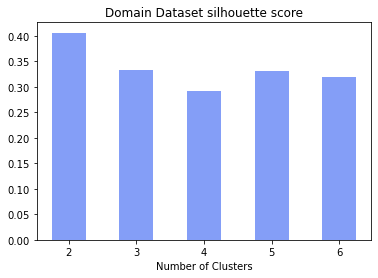

In [239]:
# candidate values for our number of cluster
parameters = [2, 3, 4, 5, 6]

# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []

# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)  # set current hyper parameter
    kmeans_model.fit(domain_resized)     # fit model on dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(domain_resized, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
        
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#849ef7', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Domain Dataset silhouette score')
plt.xlabel('Number of Clusters')
plt.show()

* 다음으로 Public dataset

In [240]:
### 3 component dimensionality reduction on merged dataset
pub_pca_3 = decomposition.PCA(n_components=3)
pub_pca_3_result = pub_pca_3.fit_transform(public_resized)
pub_3 = pub_pca_3.explained_variance_ratio_.sum()*100

### check the representativeness of the reduced dimension by PCA
print('Explained variation per principal component: {}'.format(pub_pca_3.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pub_pca_3.explained_variance_ratio_)))

Explained variation per principal component: [0.61751917 0.18381052 0.11707809]
Cumulative variance explained by 2 principal components: 91.84%


* 마찬가지로 그림으로 그려서 확인

In [241]:
# pub_result3 = pd.DataFrame(pub_pca_3.transform(public_resized), columns = ['PCA%i' % i for i in range(3)], index = public_resized.index)

In [242]:
# # Plot initialisation
# fig = plt.figure(figsize=(8,5))
# ax = fig.add_subplot(111, projection='3d')
# plt.title('PCA 3 result from Public Dataset', fontsize=11, fontweight='bold')
# ax.scatter(pub_result3['PCA0'], pub_result3['PCA1'], pub_result3['PCA2'], s=60)
# # plt.savefig('pca_result.png')

Parameter: {'n_clusters': 2} Score 0.444634380564339
Parameter: {'n_clusters': 3} Score 0.46413732419277787
Parameter: {'n_clusters': 4} Score 0.49707292659319147
Parameter: {'n_clusters': 5} Score 0.48975389057663865
Parameter: {'n_clusters': 6} Score 0.514140549936088


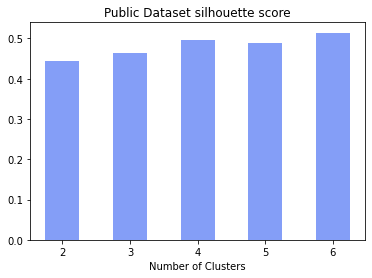

In [243]:
# candidate values for our number of cluster
parameters = [2, 3, 4, 5, 6]

# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []

# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)  # set current hyper parameter
    kmeans_model.fit(public_resized)     # fit model on dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(public_resized, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
        
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#849ef7', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Public Dataset silhouette score')
plt.xlabel('Number of Clusters')
plt.show()

## 05. Data Clustering (SSL based)

## 06. Unlabeled data labeling

* 여기서 RDATA는 Real dataset이고 PDATA는 augmentation을 위한 public dataset

In [244]:
RDATA = domain_s
PDATA = public_s1.sample(n=700)
label = domain_y

* 일단 PDATA는 unlabeled data 상태이기에 -1로 라벨값 만들어주고.

In [245]:
PDATA['y'] = -1

In [246]:
PDATA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 73233 to 326552
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSSD   700 non-null    float64
 1   HR      700 non-null    float64
 2   PNN50   700 non-null    float64
 3   VLF     700 non-null    float64
 4   LF      700 non-null    float64
 5   HF      700 non-null    float64
 6   LF_HF   700 non-null    float64
 7   y       700 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 49.2 KB


* Regression 돌리기 위해서 test, train 나눠보자

In [248]:
# Labeled datapoints and following labels.
train_x, test_x, train_y, test_y = train_test_split(RDATA, label, test_size = 0.2, random_state = 710674)

In [249]:
print("The shape of training dataset x is:", train_x.shape)
print("The shape of test dataset x is:", test_x.shape)

The shape of training dataset x is: (383, 7)
The shape of test dataset x is: (96, 7)


In [250]:
# Unlabeled datapoints and following labels.
train_x2 = PDATA.loc[:,['RMSSD', 'HR', 'PNN50', 'VLF', 'LF', 'HF', 'LF_HF']]
train_y2 = PDATA['y']

In [251]:
print("The shape of public training dataset x is:", train_x2.shape)
print("The shape of public test dataset x is:", train_y2.shape)

The shape of public training dataset x is: (700, 7)
The shape of public test dataset x is: (700,)


In [252]:
# Concatenate
x = np.concatenate((train_x, train_x2))
y = np.concatenate((train_y, train_y2))

In [253]:
print("The shape of Total training dataset x is:", x.shape)
print("The shape of Total test dataset x is:", y.shape)

The shape of Total training dataset x is: (1083, 7)
The shape of Total test dataset x is: (1083,)


* Logistic regression 돌려서 변수간 연관성 및 함수를 확인한다

In [264]:
index = ['Analysis Method', 'ROC AUC']
results = pd.DataFrame(columns = index) ## result 라고 데이터프레임 하나 만들어놓고.

In [265]:
logreg = LogisticRegression(random_state = 710674, C = 0.00001, max_iter = 20000)
logreg.fit(train_x, train_y)
results = results.append(
    pd.Series(['Logistic Regression', roc_auc_score(test_y, logreg.predict_proba(test_x), multi_class='ovr')],
              index=index), ignore_index=True)

results

,Analysis Method,ROC AUC
0,Logistic Regression,0.522648


In [266]:
# logreg.predict_proba(test_x)

In [267]:
y_pred = logreg.predict(test_x)
acc_score = accuracy_score(test_y, y_pred)

In [268]:
acc_score

0.5520833333333334

* 각 라벨별 변수에 대한 계수(coefficient)를 확인

In [269]:
logreg.coef_

array([[-3.73974231e-06, -4.38068275e-05,  4.23036071e-05,
        -1.18759519e-05, -1.52610468e-05, -1.46237467e-05,
        -1.76656185e-05],
       [-5.84416223e-06, -9.40715629e-06, -3.69849336e-05,
         6.27348055e-07,  7.92003425e-07,  1.51756840e-07,
         2.67909830e-07],
       [ 9.58390454e-06,  5.32139838e-05, -5.31867359e-06,
         1.12486038e-05,  1.44690433e-05,  1.44719898e-05,
         1.73977087e-05]])

* Label propagation (generating probablistic transition matrix for unlabeled datapoints)

In [ ]:
def label_prop_test(kernel, params_list,x_train, x_test, y_train, y_test):
    plt.figure(figsize=(20,10))
    n, g = 0, 0
    roc_scores = []
    
    if kernel == 'rbf':
        for g in params_list:
            lp = LabelPropagation(kernel=kernel, n_neighbors=n, gamma=g, max_iter=10000, tol=0.001)
            lp.fit(x_train, y_train)
            roc_scores.append(roc_auc_score(y_test, lp.predict_proba(x_test), multi_class='ovr'))
    
    if kernel == 'knn':
        for n in params_list:
            lp = LabelPropagation(kernel=kernel, n_neighbors=n, gamma=g, max_iter=10000, tol=0.001)
            lp.fit(x_train, y_train)
            roc_scores.append(roc_auc_score(y_test, lp.predict_proba(x_test), multi_class='ovr'))
    
    plt.figure(figsize=(16,8));
    plt.plot(params_list, roc_scores)
    plt.title('Label Propagation ROC AUC with ' + kernel + ' kernel')
    plt.show()
    
    print('Best metrics value is at {}'.format(params_list[np.argmax(roc_scores)]))